# Load File Names

In [1]:
import glob
import tensorflow as tf

dataset_dir = 'ISIC2018_Task1-2_Training_Data/'
input_dir = dataset_dir + 'ISIC2018_Task1-2_Training_Input_x2/'
groundtruth_dir = dataset_dir + 'ISIC2018_Task1_Training_GroundTruth_x2/'

input_filenames = glob.glob(input_dir + '/*.jpg')
input_filenames = sorted(input_filenames)

groundtruth_filenames = glob.glob(groundtruth_dir + '/*.png')
groundtruth_filenames = sorted(groundtruth_filenames)

# sanity check
assert len(input_filenames) == len(groundtruth_filenames) # 2594
test_size = int(len(input_filenames) * .2)

# Train/Test Split

In [2]:
input_filenames = input_filenames[:15] #
groundtruth_filenames = groundtruth_filenames[:15] #
test_size = int(len(input_filenames) * .2)

train_images, train_labels = input_filenames[test_size:], groundtruth_filenames[test_size:]
test_images, test_labels = input_filenames[:test_size], groundtruth_filenames[:test_size]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Read Images & Pre-process Data

In [3]:
def map_fn(image_filename, label_filename):
    # input image
    img = tf.io.read_file(image_filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = img / 255.

    # ground truth image
    label = tf.io.read_file(label_filename)
    label = tf.io.decode_jpeg(label, channels=1)
    label = tf.image.resize(label, (256, 256))
    label = label / 255.
    label = tf.cast(label > 0.5, dtype=tf.float32) # mask

    return img, label

train_ds = train_ds.map(map_fn)
test_ds = test_ds.map(map_fn)

train_ds = train_ds.batch(32)
test_ds = test_ds.batch(32)

# for img, label in train_ds:
#     print(img.shape)
#     print(tf.reduce_max(img), tf.reduce_min(img)) # between 0.0 and 1.0
    
#     print(label.shape)
#     print(tf.reduce_max(label), tf.reduce_min(label)) # only 0.0 and 1.0

#     break

# Visualization

In [4]:
# import matplotlib.pyplot as plt

# label_img_sample = tf.io.read_file(val_labels[2])
# label_img_sample = tf.io.decode_jpeg(label_img_sample, channels=1)
# label_img_sample = tf.image.resize(label_img_sample, (256, 256))

# plt.imshow(label_img_sample.numpy()[:, :, 0]/255. > 0.5, cmap='gray')
# plt.show()

In [5]:
# input_img_sample = tf.io.read_file(val_images[2])
# input_img_sample = tf.io.decode_jpeg(input_img_sample, channels=3)
# input_img_sample = tf.image.resize(input_img_sample, (256, 256))

# plt.imshow(input_img_sample.numpy()/255.)
# plt.show()

# Improved U-Net Model

In [6]:
# !pip install tensorflow_addons
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow_addons.layers import InstanceNormalization


def context_module(pre_layer, n_filters, leaky_slope=1e-2, dropout_rate=0.3):

    # 1st
    norm1 = InstanceNormalization()(pre_layer)
    leakyRelu1 = LeakyReLU(alpha=leaky_slope)(norm1)
    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', use_bias=False)(leakyRelu1)

    dropout = Dropout(dropout_rate)(conv1)

    # 2nd
    norm2 = InstanceNormalization()(dropout)
    leakyRelu2 = LeakyReLU(alpha=leaky_slope)(norm2)
    conv2 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', use_bias=False)(leakyRelu2)

    return conv2


def localization_module(pre_layer, n_filters, leaky_slope=1e-2):

    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', 
                    activation=LeakyReLU(leaky_slope))(pre_layer)
    norm1 = InstanceNormalization()(conv1)
    # leakyRelu1 = LeakyReLU(alpha=leaky_slope)(norm1)

    conv2 = Conv2D(filters=n_filters/2, kernel_size=1, strides=1, padding='same',
                    activation=LeakyReLU(leaky_slope))(norm1)
    norm2 = InstanceNormalization()(conv2)
    # leakyRelu2 = LeakyReLU(alpha=leaky_slope)(norm2)

    return norm1, norm2

def improved_UNet(input_shape=(256, 256, 3), n_filters=16, n_classes=1, dropout_rate=0.3, leaky_slope=1e-2):
    
    input_layer = Input(shape=input_shape)

    # context pathway 1
    con1_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same')(input_layer) # TODO: bias
    con1_context = context_module(con1_conv, n_filters*1, leaky_slope, dropout_rate)
    con1_context += con1_conv
    
    # context pathway 2
    con2_conv = Conv2D(n_filters*2, kernel_size=3, strides=2, padding='same')(con1_context) # TODO: use_bias=False
    con2_context = context_module(con2_conv, n_filters*2, leaky_slope, dropout_rate)
    con2_context += con2_conv

    # context pathway 3 
    con3_conv = Conv2D(n_filters*4, kernel_size=3, strides=2, padding='same')(con2_context) 
    # con3_norm = InstanceNormalization()(con3_conv)
    con3_context = context_module(con3_conv, n_filters*4, leaky_slope, dropout_rate)
    con3_context += con3_conv

    # context pathway 4
    con4_conv = Conv2D(n_filters*8, kernel_size=3, strides=2, padding='same')(con3_context)
    # con4_norm = InstanceNormalization()(con4_conv)
    con4_context = context_module(con4_conv, n_filters*8, leaky_slope, dropout_rate)
    con4_context += con4_conv

    # context pathway 5 (bottom)
    con5_conv = Conv2D(n_filters*16, kernel_size=3, strides=2, padding='same')(con4_context)
    # con5_norm = InstanceNormalization()(con5_conv)
    con5_context = context_module(con5_conv, n_filters*16, leaky_slope, dropout_rate)
    con5_context += con5_conv

    # localization pathway 1 (bottom)
    local1_up = UpSampling2D()(con5_context)
    local1_conv = Conv2D(n_filters*8, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local1_up) # TODO: use_bias=False

    # localization pathway 2
    local2_concat = concatenate([local1_conv, con4_context])
    _, local2_localization = localization_module(local2_concat, n_filters*8, leaky_slope)
    local2_up = UpSampling2D()(local2_localization)
    local2_conv = Conv2D(n_filters*4, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local2_up) # TODO: use_bias=False
    
    # localization pathway 3
    local3_concat = concatenate([local2_conv, con3_context])
    tmp_1, local3_localization = localization_module(local3_concat, n_filters*4, leaky_slope)
    local3_up = UpSampling2D()(local3_localization)
    local3_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local3_up) # TODO: use_bias=False
    
    # localization pathway 4
    local4_concat = concatenate([local3_conv, con2_context])
    tmp_2, local4_localization = localization_module(local4_concat, n_filters*2, leaky_slope)
    local4_up = UpSampling2D()(local4_localization)
    local4_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local4_up)
    
    # final level (top)
    final_concat = concatenate([local4_conv, con1_context])
    final_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                        activation=LeakyReLU(leaky_slope))(final_concat)

    # segmentations
    seg_1 = Conv2D(n_classes, kernel_size=1, strides=1, padding='valid',# activation=LeakyReLU(leaky_slope), use_bias=False
                    )(tmp_1)
    seg_1_up = UpSampling2D(interpolation='bilinear')(seg_1)

    seg_2 = Conv2D(n_classes, kernel_size=1, strides=1, padding='valid',# activation=LeakyReLU(leaky_slope), use_bias=False
                    )(tmp_2)
    seg_2_up = UpSampling2D(interpolation='bilinear')(seg_2+seg_1_up)

    seg_3 = Conv2D(n_classes, kernel_size=1, strides=1, padding='valid',# activation=LeakyReLU(leaky_slope), use_bias=False
                    )(final_conv)
    final_add = seg_2_up + seg_3

    # sigmoid
    pre = Activation('sigmoid')(final_add)

    return Model(inputs = input_layer, outputs = pre)

model = improved_UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

In [7]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(y_pred * y_true)
    X = K.sum(y_pred)
    Y = K.sum(y_true)
    
    dice = (2. * intersection + smooth) / (X + Y + smooth)
    return dice

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])
# model_callback=tf.keras.callbacks.ModelCheckpoint(filepath='best_checkpoint', save_best_only= True,
#                                                   save_weights_only=True, monitor = 'val_accuracy', mode='max')
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
history = model.fit(x=train_ds, epochs=6, validation_data=test_ds, shuffle=True) #batch_size=32)

Epoch 1/6
1/1 [==============================] - 8s 8s/step - loss: 0.7726 - dice_coef: 0.2274 - accuracy: 0.2838 - val_loss: 0.2223 - val_dice_coef: 0.7777 - val_accuracy: 0.9078
Epoch 2/6
1/1 [==============================] - 4s 4s/step - loss: 0.3910 - dice_coef: 0.6090 - accuracy: 0.8437 - val_loss: 0.1352 - val_dice_coef: 0.8648 - val_accuracy: 0.9375
Epoch 3/6
1/1 [==============================] - 4s 4s/step - loss: 0.2657 - dice_coef: 0.7343 - accuracy: 0.8951 - val_loss: 0.1154 - val_dice_coef: 0.8846 - val_accuracy: 0.9434
Epoch 4/6
1/1 [==============================] - 4s 4s/step - loss: 0.2049 - dice_coef: 0.7951 - accuracy: 0.9179 - val_loss: 0.1629 - val_dice_coef: 0.8371 - val_accuracy: 0.9110
Epoch 5/6
1/1 [==============================] - 4s 4s/step - loss: 0.1670 - dice_coef: 0.8330 - accuracy: 0.9337 - val_loss: 0.2920 - val_dice_coef: 0.7080 - val_accuracy: 0.8362
Epoch 6/6
1/1 [==============================] - 4s 4s/step - loss: 0.1412 - dice_coef: 0.8588 - acc

# Prediction Result Visualization

In [9]:
img = tf.io.read_file(train_images[3])
img = tf.io.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (256, 256))
img = img / 255.
img = tf.expand_dims(img, axis=0)

In [10]:
img_pred = model.predict(img)
img_pred[0].shape

(256, 256, 1)

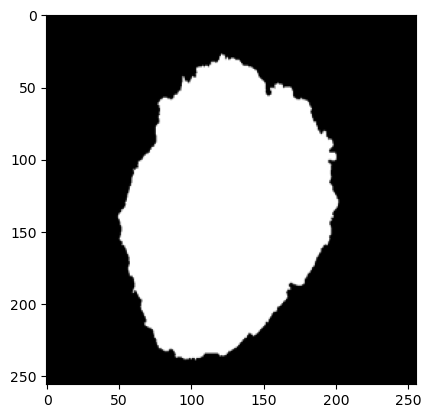

In [11]:
import matplotlib.pyplot as plt

label_img_sample = tf.io.read_file(train_labels[3])
label_img_sample = tf.io.decode_jpeg(label_img_sample, channels=1)
label_img_sample = tf.image.resize(label_img_sample, (256, 256))

plt.imshow(label_img_sample.numpy()[:, :, 0]/255., cmap='gray')
plt.show()

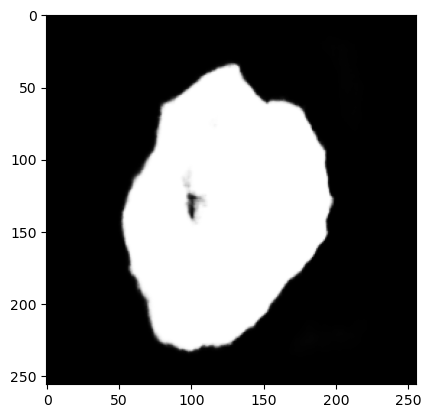

In [12]:
plt.imshow(img_pred[0], cmap='gray')
plt.show()

In [13]:
# dice_coef(img_true, img_pred[0])